In [1]:
%matplotlib notebook

In [2]:
import numpy as np

from scipy import linalg
from scipy import sparse


import sklearn.metrics.pairwise as knl
from sklearn import datasets
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

from mpl_toolkits.mplot3d import Axes3D

import tadasets

from ripser import ripser
from persim import plot_diagrams

import seaborn as sns

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from PIL import Image



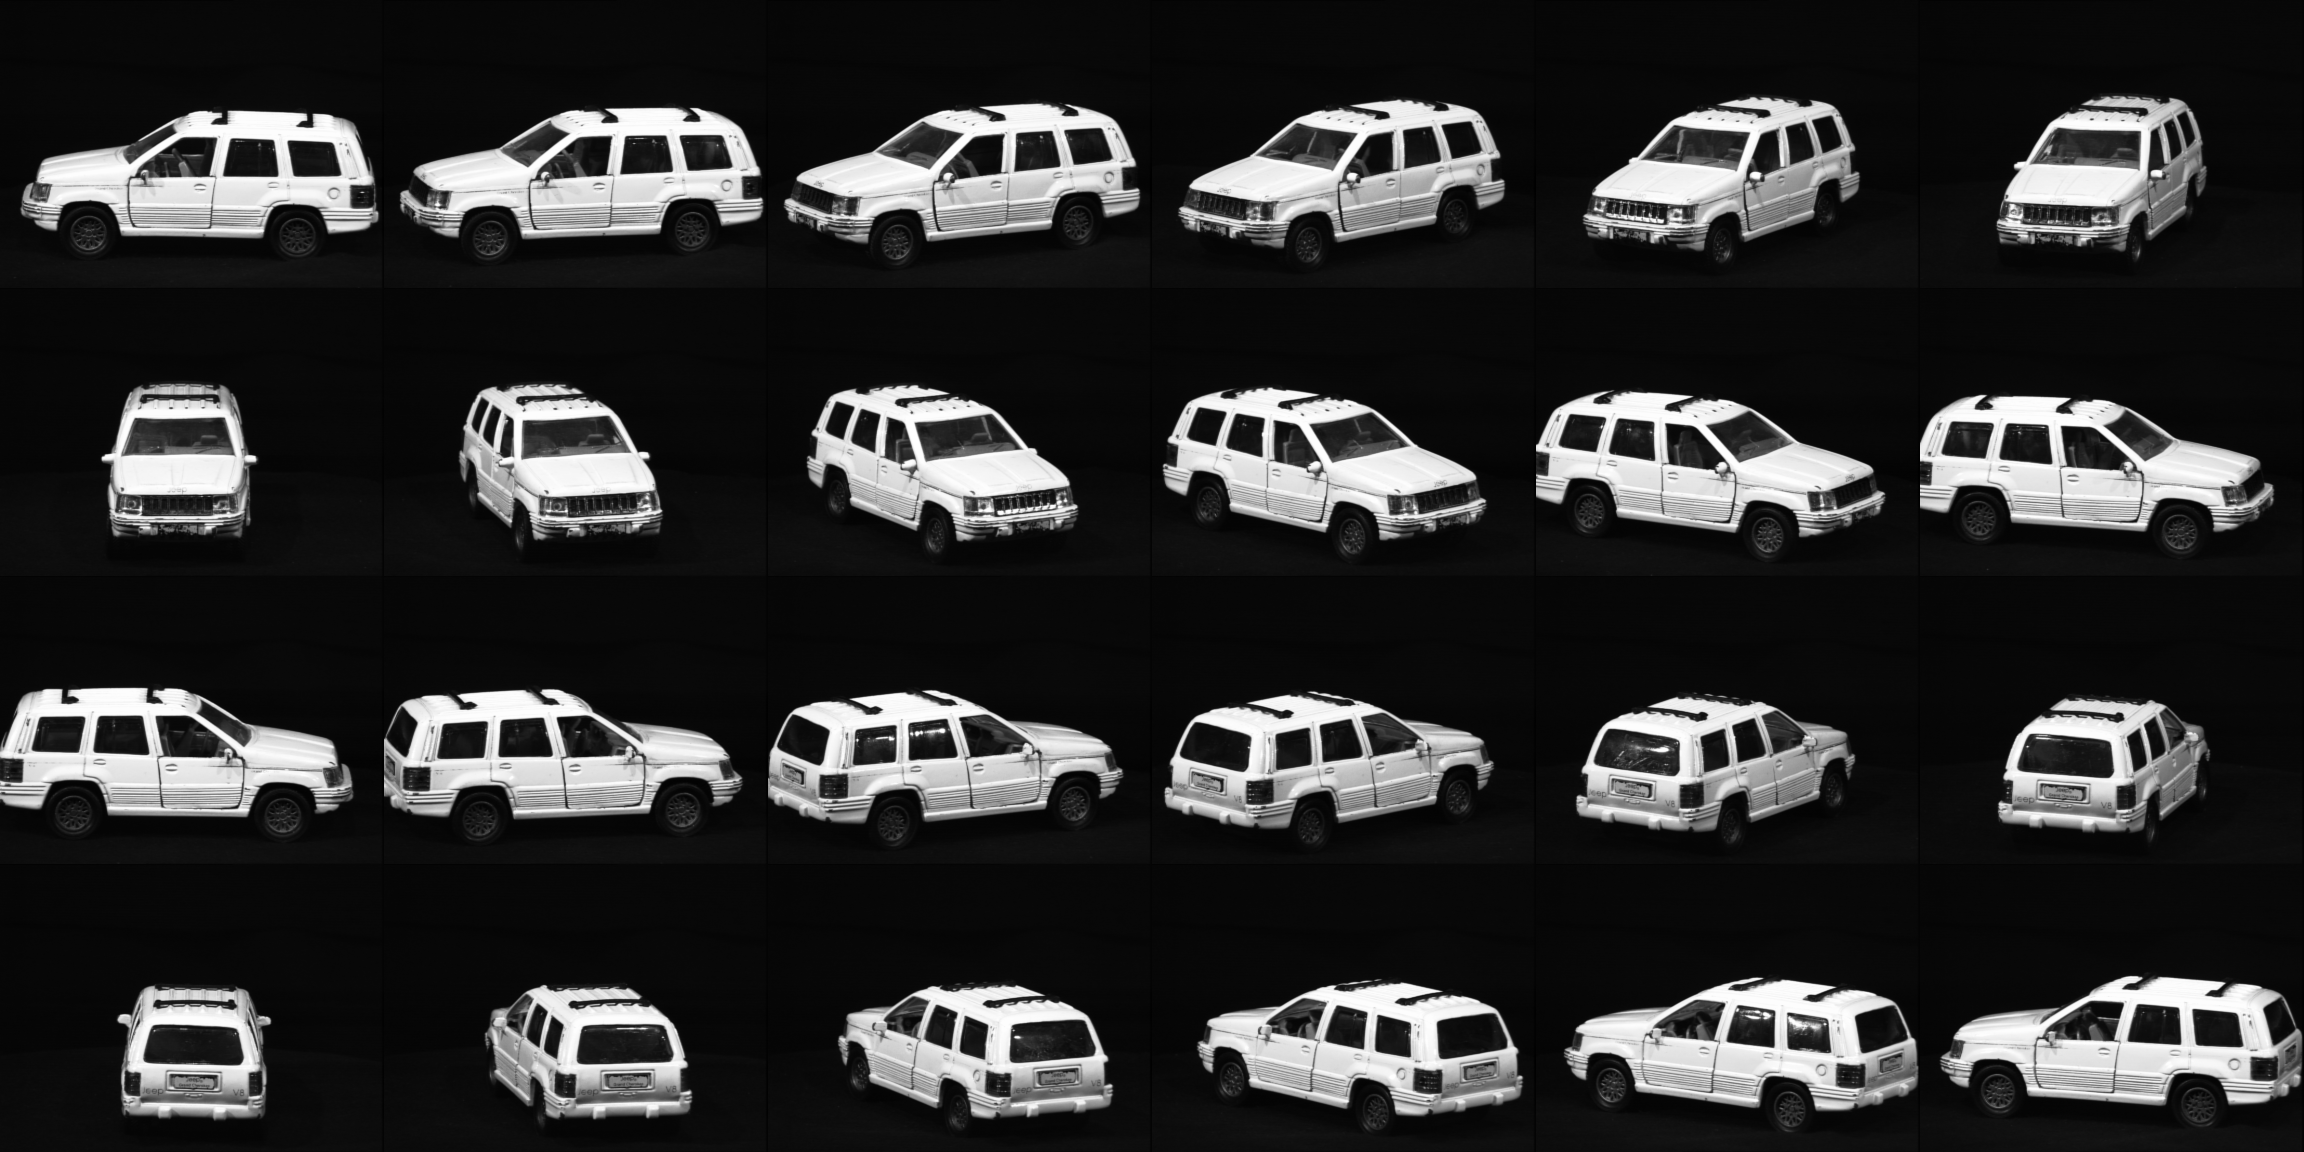

In [3]:
#plot a selection of the images - there are 72 in total

fs = []
#fetch 24 images, corresponding to equi-spaced camera locations
for i in range(0,360,15):
    im = Image.open('data/car_data/car_images/160_r%i.png' % i, 'r')
    fs.append(im)
    
# get the image size
x_im,y_im = fs[0].size

ncol = 6
nrow = 4
cvs = Image.new('RGB',(x_im*ncol,y_im*nrow))

for i in range(len(fs)):
    px, py = x_im*(i%ncol), y_im*int(i/ncol)
    cvs.paste(fs[i],(px,py))
    
cvs

In [ ]:
cvs.save('cars_combined.png',format='png')

In [27]:
#get the car data

Y = np.genfromtxt('data/car_data/car_pixels.csv',delimiter=',',skip_header=1)
Y = np.asmatrix(Y)

m = Y.mean(axis=0)
Y = Y - m
Y = Y.T

theta = np.arange(0,360,5) #angles from which photos are taken

In [28]:
n = np.shape(Y)[0]
p = np.shape(Y)[1]
r_max = 72
print(p)
print(n)

110592
72


In [32]:
U, s, Vh = sparse.linalg.svds(Y.T,k=r_max-1) #max value of k = min(X.T.shape) -1, depending on which svd solver is used 

idx = np.argsort(s)
idx = np.flip(idx)
U = U[:,idx]
s = s[idx]
Vh = Vh[idx,:]

<IPython.core.display.Javascript object>


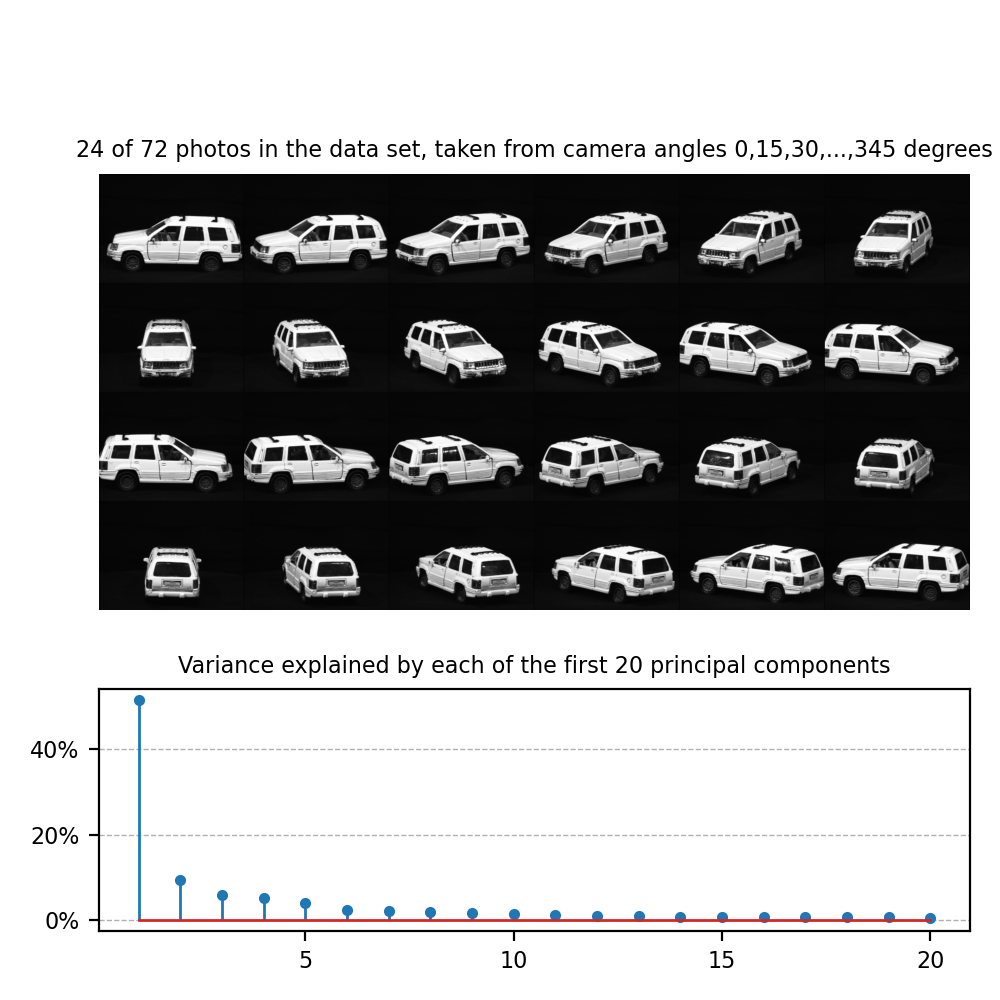

In [30]:
image = plt.imread('cars_combined.png')


fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
fig.set_size_inches(5, 5)

ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('24 of 72 photos in the data set, taken from camera angles 0,15,30,...,345 degrees',fontsize = 8)

r_plot = 20
percent_var = s[0:r_plot]**2/sum(s**2)

markerline, stemline, baseline, = ax[1].stem(range(1,r_plot+1),100*percent_var)
#ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xticks([5,10,15,20])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax[1].grid(axis='y', linestyle='--', linewidth=0.5)
ax[1].set_title('Variance explained by each of the first 20 principal components', fontsize = 8)

plt.setp(stemline, linewidth = 1)
plt.setp(markerline, markersize = 3)
plt.setp(baseline, linewidth = 1)

fig.subplots_adjust(hspace=-.2)
fig.tight_layout()


In [ ]:
plt.savefig('cars_and_var.png', bbox_inches='tight', pad_inches=0)

In [90]:
plt.savefig('cars_and_var.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1200)

In [8]:
import ot
from tqdm import tqdm
def wasserstein_dim_select(Y, split = 0.5, rmin = 1, rmax = 50):
    n = Y.shape[0]
    train = round(n * split)
    rtry = int(np.min((train, rmax)))
    if sparse.issparse(Y):
        Y = Y.todense()
    Ytrain = Y[:train,:]
    Ytest = Y[train:n,:]
    U, s, Vh = sparse.linalg.svds(Ytrain,k=rtry-1)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    ws = []
    for r in tqdm(range(rmin,rtry+1)):
        P = Vh.T[:,:r] @ Vh[:r,:]
        Yproj = Ytrain @ P.T
        n1 = Yproj.shape[0]
        n2 = Ytest.shape[0]
        M = ot.dist(Yproj,Ytest, metric='euclidean')
        W1 = ot.emd2(np.repeat(1/n1,n1),np.repeat(1/n2,n2),M)
        ws.append(W1)
    return ws

<IPython.core.display.Javascript object>


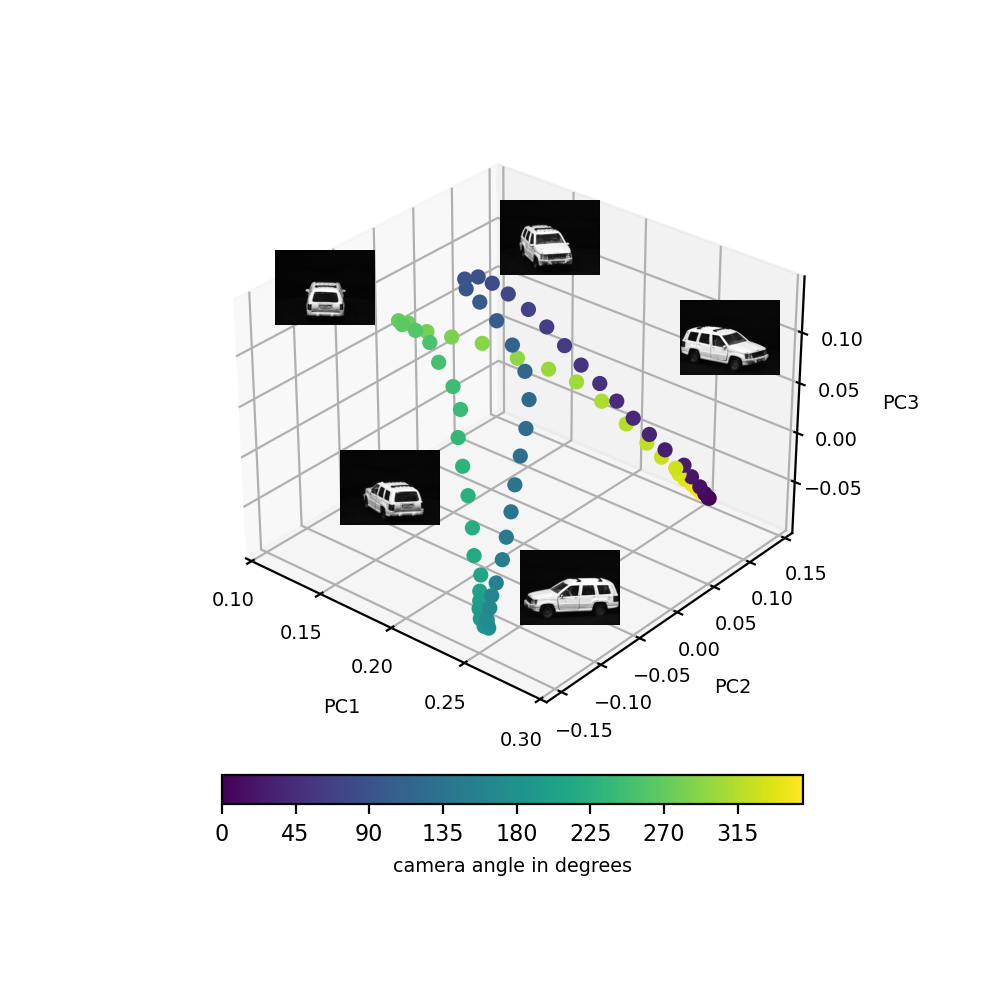

In [33]:
#NB factor of p^-1/2 included in zeta - see main consistency theorem 
zeta_r_max = np.diag(s[0:r_max]) @ Vh[0:r_max,:] /p**0.5 
zeta_r_max = zeta_r_max.T

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(zeta_r_max[:,0], zeta_r_max[:,1], zeta_r_max[:,2],  marker='o', c=theta, cmap='viridis', alpha=1) #c=color,
ax.set_xlabel('PC1', labelpad=0.5)
ax.set_ylabel('PC2', labelpad=0.5)
ax.set_zlabel('PC3', labelpad=0.5)

elev = 30.0
azim =310.0
ax.view_init(elev, azim)
ax.set_xlim(0.1,0.3)
ax.set_xticks([0.1,0.15,0.2,0.25,0.3])
ax.tick_params(axis='x', pad=0.3, labelsize = 'x-small')
ax.tick_params(axis='y', pad=0.3, labelsize = 'x-small')
ax.tick_params(axis='z', pad=0.3, labelsize = 'x-small')


#each time the SVD is calculated it may return different signs of the singular vectors
#corresponding to some orthogonal transformation of the PC scores - so need
#to adjust above axis limmits and the placement of the below images accordingly to place below images accordingly

#arr_image = plt.imread('car_images/160_r0.png', format='png')
arr_image = plt.imread('data/car_data/car_images/160_r140.png', format='png')
newax = fig.add_axes([0.68, 0.6, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

#arr_image = plt.imread('car_images/160_r45.png', format='png')
arr_image = plt.imread('data/car_data/car_images/160_r15.png', format='png')
newax = fig.add_axes([0.52, 0.35, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

#arr_image = plt.imread('car_images/160_r90.png', format='png')
arr_image = plt.imread('data/car_data/car_images/160_r290.png', format='png')
newax = fig.add_axes([0.34, 0.45, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

#arr_image = plt.imread('car_images/160_r180.png', format='png')
arr_image = plt.imread('data/car_data/car_images/160_r105.png', format='png')
newax = fig.add_axes([0.5, 0.7, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

arr_image = plt.imread('data/car_data/car_images/160_r270.png', format='png')
newax = fig.add_axes([0.275, 0.65, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')


fig.colorbar(im, ax=ax, shrink=0.75, location='bottom', pad = 0.05, label='camera angle in degrees', ticks=[0,45,90,135,180,225,270,315,360])

In [ ]:
plt.savefig('cars_embedding_plus.png', bbox_inches='tight', pad_inches=0)

In [35]:
rng = np.random.default_rng(seed=123)

In [36]:
#Wasserstein dimension selection - very slow ir run on Y, so instead run on zeta with maximum rank
rmin = 1
rmax = 35
ws = wasserstein_dim_select(rng.permutation(zeta_r_max), rmin=rmin, rmax=rmax,split=0.5)
dim = np.argmin(ws)+rmin
print(f'Number of dimensions selected: {dim}')


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 2203.35it/s]

Number of dimensions selected: 11


<IPython.core.display.Javascript object>


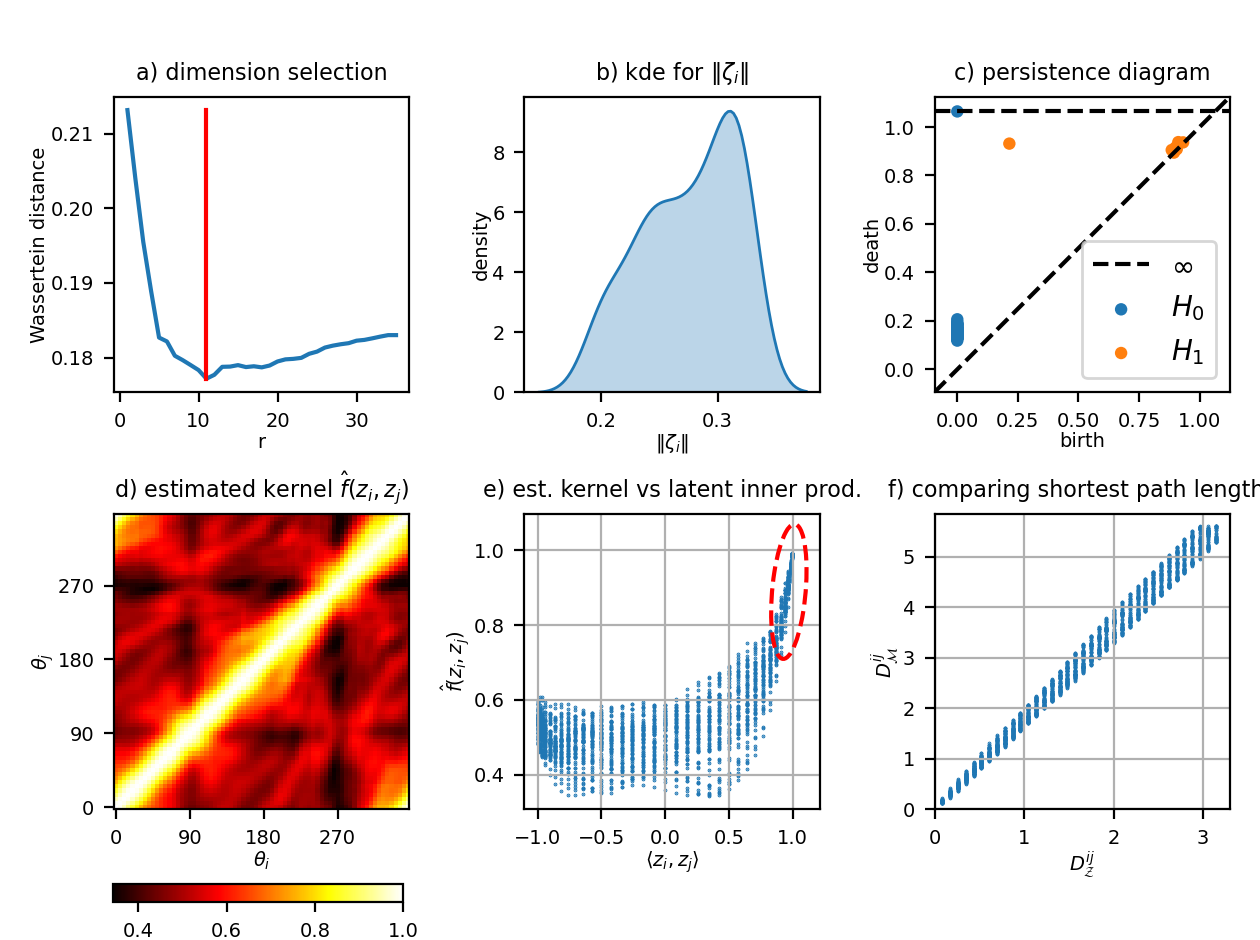

In [37]:

fig = plt.figure(figsize=(6.3,4.7)) #figsize is in inches: A4 is 8.3 inches wide, so 6.3 fits with 1-inch margins
ax = fig.add_subplot(231)
ax.plot(range(rmin,rmax+1),ws)
ax.plot([dim,dim], [min(ws),max(ws)], c='r')

fontsize = 7
titlesize = 8
labelpad = 0.7

ax.set_xlabel('r', fontsize=fontsize, labelpad=1)
ax.set_ylabel('Wassertein distance', fontsize=fontsize, labelpad=labelpad)
ax.tick_params(labelsize=fontsize)
ax.set_title(r"a) dimension selection", fontsize=titlesize)
ax.set_box_aspect(1)

In [38]:
zeta = zeta_r_max[:,0:dim] #keep the selected number of dimensions
zeta_mags = np.linalg.norm(zeta,axis = 1)
zeta_cos_sim = cosine_similarity(zeta)
cos_theta_dif = np.cos(np.radians(np.outer(theta,np.ones(72)) - np.outer(np.ones(72),theta)))

In [39]:
ax = fig.add_subplot(232)
#ax.stem(theta,zeta_mags)
sns.kdeplot(x=zeta_mags, ax=ax, gridsize = 100, fill=True, alpha = 0.3)
ax.set_xlabel(r"$\|\zeta_i\|$", fontsize=fontsize, labelpad=labelpad )
ax.set_ylabel(r"density", fontsize=fontsize, labelpad=labelpad)
ax.set_title(r"b) kde for $\|\zeta_i\|$", fontsize=titlesize)
ax.tick_params(labelsize=fontsize)
ax.set_box_aspect(1)


In [40]:
#fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(233)
diagram = ripser(zeta/zeta_mags[:,None], maxdim=1)['dgms']
plot_diagrams(diagram,show=True, ax=ax)
ax.set_xlabel(r"birth", fontsize=fontsize, labelpad=labelpad )
ax.set_ylabel(r"death", fontsize=fontsize, labelpad=labelpad )
ax.set_title(r"c) persistence diagram", fontsize=titlesize)
ax.tick_params(labelsize=fontsize)

In [41]:
W = radius_neighbors_graph(zeta/zeta_mags[:,None], radius=0.25, mode='distance', include_self=False)
G=nx.from_scipy_sparse_array(W, parallel_edges=False, create_using=None, edge_attribute='weight')
sp_lengths_zeta = dict(nx.all_pairs_dijkstra_path_length(G, weight = 'weight'))
sp_lengths_zeta_array = np.zeros((n,n))
for i in sp_lengths_zeta.keys():
    for j in sp_lengths_zeta[i].keys():
        sp_lengths_zeta_array[i,j] = sp_lengths_zeta[i][j]

In [42]:
Z = np.column_stack([np.cos(np.radians(theta)), np.sin(np.radians(theta))])
WZ = kneighbors_graph(Z, n_neighbors=2, mode='distance', include_self=False)
GZ=nx.from_scipy_sparse_array(WZ, parallel_edges=False, create_using=None, edge_attribute='weight')
sp_lengths_Z = dict(nx.all_pairs_dijkstra_path_length(GZ, weight = 'weight'))
sp_lengths_Z_array = np.zeros((n,n))
for i in sp_lengths_Z.keys():
    for j in sp_lengths_Z[i].keys():
        sp_lengths_Z_array[i,j] = sp_lengths_Z[i][j]

In [43]:
ax = fig.add_subplot(234)
im  = ax.imshow(zeta_cos_sim, cmap='hot', interpolation='nearest', origin='lower')
ax.set_xticks([0,18,36,54], labels = [0,90,180,270])
ax.set_yticks([0,18,36,54], labels = [0,90,180,270])
ax.set_xlabel(r"$\theta_i$", fontsize=fontsize, labelpad=labelpad )
ax.set_ylabel(r"$\theta_j$", fontsize=fontsize, labelpad=labelpad )
ax.set_title(r"d) estimated kernel $\hat{f}(z_i,z_j)$", fontsize=titlesize)
ax.tick_params(labelsize=fontsize)


In [44]:
from matplotlib import patches

In [45]:
ax = fig.add_subplot(235)
ax.scatter(cos_theta_dif[np.triu_indices(n=n,k=1)], zeta_cos_sim[np.triu_indices(n=n,k=1)], s=0.5, marker='.')
ax.set_xlabel(r"$\langle z_i,z_j\rangle$", fontsize=fontsize, labelpad=labelpad )
ax.set_ylabel(r"$\hat{f}(z_i,z_j)$", fontsize=fontsize, labelpad=labelpad )
ax.set_title(r"e) est. kernel vs latent inner prod.", fontsize =titlesize)

e1 = patches.Ellipse((0.97, 0.89), 0.25, 0.38,
                     angle=-25, linewidth=1.5, fill=False, zorder=2, linestyle='--', edgecolor='red')

ax.add_patch(e1)
ax.grid(True)

ax.tick_params(labelsize=fontsize)
ax.set_box_aspect(1)

In [46]:
ax = fig.add_subplot(236)
ax.scatter(sp_lengths_Z_array[np.triu_indices(n=n,k=1)], sp_lengths_zeta_array[np.triu_indices(n=n,k=1)], s=0.5, marker='.')
ax.set_xlabel(r"$D^{ij}_{\mathcal{Z}}$", fontsize=fontsize, labelpad=labelpad )
ax.set_ylabel(r"$D^{ij}_{\mathcal{M}}$", fontsize=fontsize, labelpad=labelpad )
ax.set_title(r"f) comparing shortest path lengths", fontsize = titlesize)
ax.tick_params(labelsize=fontsize)
ax.grid(True)
ax.set_box_aspect(1)
ax.set_xlim(0,3.3)
ax.set_ylim(0,5.85)

(0.0, 5.85)

In [47]:
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

In [48]:
cbar_ax = fig.add_axes([0.09, 0.04, 0.23, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal')
cbar_ax.tick_params(labelsize=fontsize)

In [145]:
plt.savefig('cars_EDA.png', dpi=300, format='png', bbox_inches='tight')